In [23]:
import pandas as pd
%run ../load-results.ipynb import GetAllResultsFromDifficulties, GetAllResultsFrom, GetDifficulty

def CalculateSessionMGPValuesOverTime(results, minScore, maxScore):
    '''
    Calcula el MGP de un grupo de resultados a partir 
    del indice de rendimiento, y devuelve una lista con
    los valores correspondientes al MGP de la sesion.
    
    Parameters:
    results (pandas.DataFrame): Una Series con los 
    indices de rendimiento de los cuales se quiere 
    obtener el MGP, ordenados de acuerdo al orden en que
    fueron jugados.
    minScore (int): El indice de rendimiento minimo que 
    existe en esta dificultad.
    maxScore (int): El indice de rendimiento maximo que 
    existe en esta dificultad.
    
    Returns:
    float[]: Listado con los MGP de la sesion.
    '''    
    
    scaledResults = pd.concat([pd.Series([minScore, maxScore]), results])
    mgpValues = []
    
    for i in range(2, scaledResults.size):
        currentPI = scaledResults.iloc[i]
        previousPIs = scaledResults.iloc[:i]
        mgpValues.append(CalculateSessionMGP(currentPI, previousPIs))
            
    return mgpValues

def CalculateSessionMGP(currentScore, previousScores):
    '''
    Calcula el MGP de un resultado a partir del indice de
    rendimiento y los resultados previos.
    
    Note: Para que funcione adecuadamente, la lista de
    scores previos tiene que contener los valores frontera
    (minimo y maximo) de la dificultad. De otro modo, el
    MGP resultante estara sesgado.
    
    Parameters:
    currentScore (int): El indice de rendimiento para el 
    cual se quiere obtener el MGP.
    previousScores (pandas.Series): Series con los
    indices de rendimiento previos del paciente en esta
    dificultad, ordenados segun fueron jugados.
    
    Returns:
    float: MGP de la sesion.
    '''
    df = pd.concat([previousScores, pd.Series([currentScore])])
    if df.min() == df.max():
        return 0.5
    
    normalizedDf = (df-df.min())/(df.max()-df.min())
    
    return normalizedDf.iloc[-1]

def GetDifficultyMinAndMaxValues(difficulty, column="Puntaje"):
    df = GetAllResultsFromDifficulties([difficulty])[column]
    return df.min(), df.max()

def RemoveNaNValues(dataframe, column="Puntaje"):
    mask = ~dataframe[column].isna()
    return dataframe[mask]

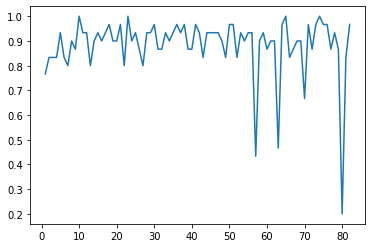

In [25]:
# Test usando IR
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = RemoveNaNValues(GetAllResultsFrom(gameSessionIds=[29]))
difficulty = GetDifficulty(df)
minScore, maxScore = GetDifficultyMinAndMaxValues(difficulty)

y = CalculateSessionMGPValuesOverTime(df["Puntaje"], minScore, maxScore)
x = np.linspace(1, len(y), len(y))

plt.plot(x, y, label='MGP')
plt.show()

C:\Users\Federico\AppData\Local\Temp\ipykernel_3620\813368981.py:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  auxDf = GetAllResultsFromDifficulties([difficulty])["Tiempo entre aciertos"].apply(lambda x: np.fromstring(x, sep=",").mean())
C:\Users\Federico\AppData\Local\Temp\ipykernel_3620\813368981.py:11: RuntimeWarning: Mean of empty slice.
  auxDf = GetAllResultsFromDifficulties([difficulty])["Tiempo entre aciertos"].apply(lambda x: np.fromstring(x, sep=",").mean())


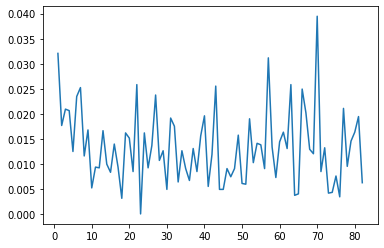

In [18]:
# Test usando tiempo de respuesta medio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = RemoveNaNValues(GetAllResultsFrom(gameSessionIds=[29]), column="Tiempo entre aciertos")

dfWithResponseTimes = df["Tiempo entre aciertos"].apply(lambda x: np.fromstring(x, sep=",").mean())

difficulty = GetDifficulty(df)
auxDf = GetAllResultsFromDifficulties([difficulty])["Tiempo entre aciertos"].apply(lambda x: np.fromstring(x, sep=",").mean())
minScore, maxScore =  auxDf.min(), 23

y = CalculateSessionMGPValuesOverTime(dfWithResponseTimes, minScore, maxScore)
x = np.linspace(1, len(y), len(y))
plt.plot(x, y, label='MGP')
plt.show()

# Disclaimer

Primero que nada, me di cuenta que estaba calculando mal el MGP. Dicho esto, el nuevo MGP tiene mas sentido y se comporta algo mejor que el anterior.

Dado este pequeño error, decidí volver a probar la mediana como medida del MGP y el comportamiento es raro. Me gusta más el suavizado que le da usar el promedio, pero puede que una vez esté más pulido, la mediana funcione mejor. De momento, es un poco inconcluso.

Por ahora y hasta que se diga explícitamente, el MGP se calcula con el promedio. 

# Pruebas nuevas

## Nuevo MGP

A continuación adjunto un gráfico con casi 100 partidas del MGP:

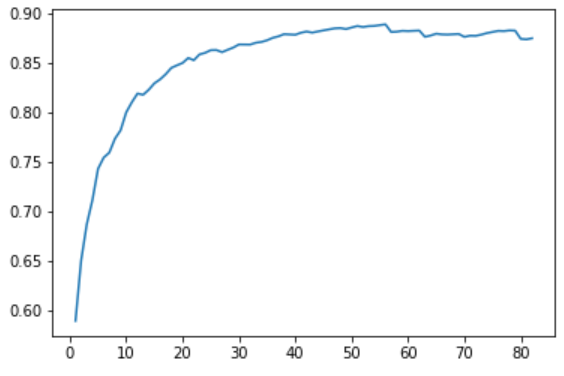

Algo que es importante notar, es que tarda al menos 20 partidas en estabilizarse en un valor concreto. De la misma forma, es muy dificil, una vez establecido este valor, que el MGP se mueva. Queda completamente sesgado, y tarda muchísimo en salirse.

Este es el gráfico de la misma lista de MGPs, adjuntando un conjunto de unos 20 valores muy muy bajos:

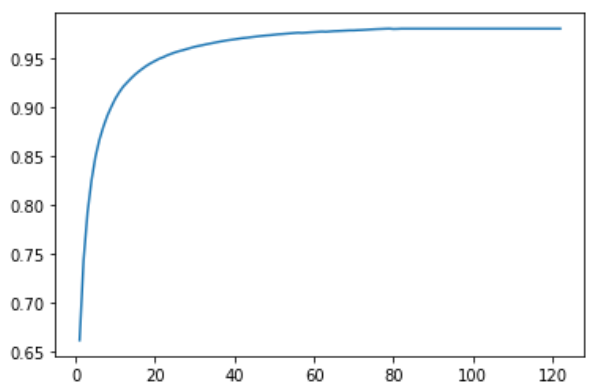

Acá notamos dos cosas. Los puntajes son tan bajos, que el MGP sube como resultado, porque el promedio general subió, pero además, no vemos el comportamiento que estamos buscando.

Mismo gráfico que el anterior, sin el sesgo inicial:

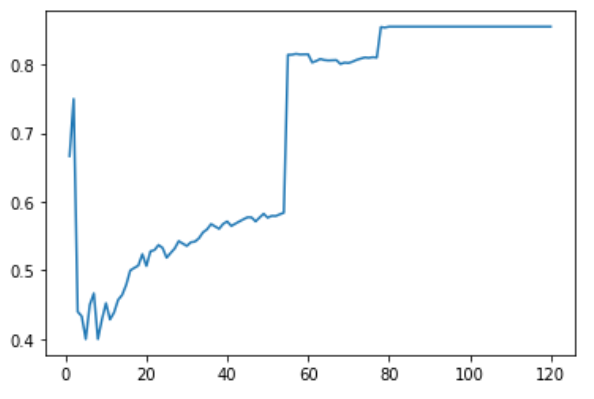

Esto es porque, cuando el IR es tan bajo que no estaba contemplado en la distribuciòn inicial, la media sube. Estamos agrandando el espectro de distribuciones posibles.

Por esto creo que el cálculo mal hecho se comporta más adecuadamente, y tiene más sentido. Porque en vez de mirar la media, vemos dónde queda el IR en la distribución.

Me queda revisar cómo lo hace Lumosity, para validar lo que estoy haciendo.

## Descubrimiento

Lo bueno, es que el mètodo es universal, y no importa el valor que se use, cambiarlo es tan fácil como cambiar la columna que se usa (y crearla si hace falta).

# Forma "correcta" de mostrar el MGP

El cálculo correcto es, dada una distribuciòn de probabilidad normalizada, el valor donde se ubica el último resultado, es nuestro MGP. Es básicamente, un IR normalizado, y sesgado sobre los resultados de un paciente en particular. 

Creo que el IR funciona muy bien, pero le hace falta un ajuste chico, como para que tenga mayor variabilidad. El tiempo medio es demasiado caótico.

## Algunas preguntas que me surgen de esto

### ¿Qué datos se tienen en cuenta para el MGP?

Lumosity sesga los datos que se usan para generar la distribución. Esto hace que cada LPI sea distinto de acuerdo al paciente y que a medida que vaya pasando el tiempo vaya mutando y ajustándose a las habilidades del paciente.

Concretamente, tomar un espectro acotado, lo que genera es que si el paciente se empieza a desempeñar mejor, primero el MGP va a subir, y después va a bajar a medida que el paciente va manteniendo su ritmo. Es decir, si está por encima de 0.5, significa que está mejorando, y si está por debajo que está empeorando, hasta que se asiente en 0.5.

Por otro lado, si tomamos todos los resultados de una dificultad concreta, podemos tener una mètrica que significa lo mismo para todos los pacientes y que es comparable. Por ejemplo, que un paciente tenga 0.8 y otro 0.7 significaría que el de 0.8 se está desempeñando mejor. Se vuelve una métrica global y transversal.

### ¿Deberíamos suavizar la curva del MGP o los MGP de mayor jerarquía ya van a mostrar esa información?

El MGP como está es bastante caótico:

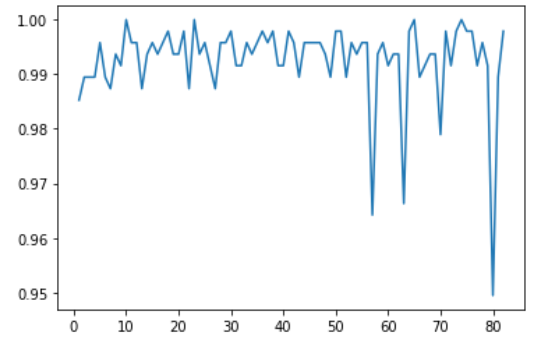

Lo que se puede hacer es usar una media, o algo del estilo para suavizar la curva, pero estoy pensando que el MGP de la planificación ya va a hacer eso, y hasta cierto punto estaría mostrando la misma información.

La contraparte de esto, es que así como está, es un poco un puntaje glorificado.

### ¿Guardamos el MGP o se calcula dinámicamente?

Esto es otra cosa que noté, y es que como el MGP es una distribución, está muy sesgado por los datos. Por ejemplo, si yo calculo el MGP de un resultado donde un paciente tuvo un IR de 458 con sus primeros 10 resultados, no va a darme lo mismo que si lo hago con los primeros 50. Es decir, va a mutar con el tiempo.

Esto tiene la consecuencia de que si yo tengo 100 resultados y recalculo uno de los primeros MGP del paciente, voy a obtener otro resultado. Pero esta misma data, nos puede servir para mostrar el progreso del paciente, contextualizado en un periodo de tiempo. Por eso me pareció interesante traerlo a colación.

Esto es lo que pasa si no se contextualizan los datos y se calcula con lo que hay:

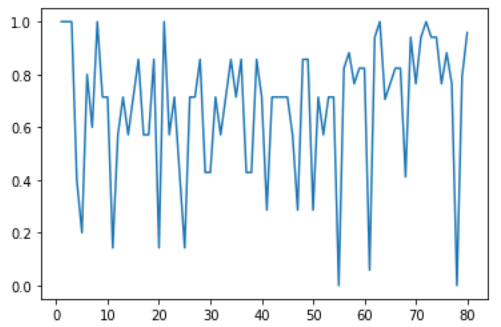

Esto se vuelve bastante caótico de leer. Para contrarrestar esto basta con contemplar los valores máximos y mínimos de todo el tiempo.

El puntaje en este momento, por como funciona, sesga los datos a puntajes altos. Necesitamos o acotar la distribución y poner un límite inferior, o cambiar el puntaje para que aproveche mejor todo el espectro de posibilidades.

Nota: No es necesario guardarlo para calcularlo y que sea estático. Me pareció más fácil de visualizar. 